### IMPORT LIBRARIES

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array


### IMPORT / VIEWING / PREPROCESSING DATASET

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [15]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [16]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


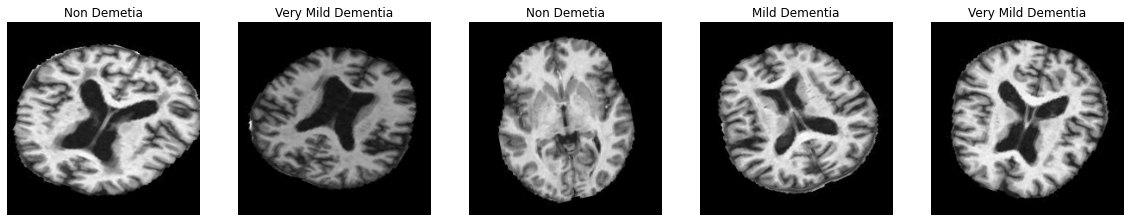

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [18]:
# Loading Model

base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [19]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [20]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

In [21]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.AUC(name = 'auc'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [23]:
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [25]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.4820 - auc: 0.7704 - accuracy: 0.7532 - precision: 0.5071 - recall: 0.4627 - f1_score: 0.4694
Epoch 00001: val_auc improved from -inf to 0.64871, saving model to ./best_weights.hdf5
33/33 [==============================] - 58s 2s/step - loss: 1.4820 - auc: 0.7704 - accuracy: 0.7532 - precision: 0.5071 - recall: 0.4627 - f1_score: 0.4694 - val_loss: 1.5264 - val_auc: 0.6487 - val_accuracy: 0.6870 - val_precision: 0.3280 - val_recall: 0.2405 - val_f1_score: 0.2769
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 1.1606 - auc: 0.8081 - accuracy: 0.7706 - precision: 0.5473 - recall: 0.4776 - f1_score: 0.4945
Epoch 00002: val_auc improved from 0.64871 to 0.75663, saving model to ./best_weights.hdf5
33/33 [==============================] - 52s 2s/step - loss: 1.1606 - auc: 0.8081 - accuracy: 0.7706 - precision: 0.5473 - recall: 0.4776 - f1_score: 0.4945 - val_loss: 1.1377 - val_auc: 0.7566 - val_accuracy

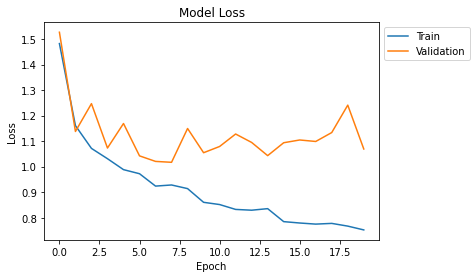

In [26]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

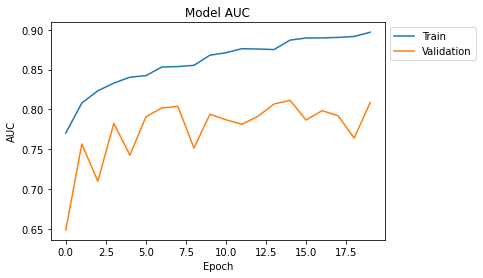

In [27]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [29]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [30]:
model.evaluate(test_dataset)


40/40 [==============================] - 9s 213ms/step - loss: 0.8263 - auc: 0.8792 - accuracy: 0.8096 - precision: 0.6296 - recall: 0.5794 - f1_score: 0.6033


[0.8263211250305176,
 0.8792129158973694,
 0.8096168637275696,
 0.6295666694641113,
 0.5793588757514954,
 0.6032977104187012]